In [1]:
import pandas as pd
import numpy as np
from pyspark.ml.classification import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt

# Data application ( prices + features)


In [2]:
aapl_with_features = pd.read_csv('../data/all_data/all_AAPL_data.csv')
googl_with_features = pd.read_csv('../data/all_data/all_GOOGL_data.csv')
msft_with_features = pd.read_csv('../data/all_data/all_MSFT_data.csv')

# Target

In [3]:
tickers = ['AAPL', 'GOOGL', 'MSFT']
data_dict = {
    'AAPL': aapl_with_features,
    'GOOGL': googl_with_features,
    'MSFT': msft_with_features
}
color_dict = {
     'AAPL': 'grey',
    'GOOGL': 'yellow',
    'MSFT': 'green'
}

In [4]:
def get_target(input_df, ticker):
    df = input_df.copy()
    df['Target'] = (df[f'Close_{ticker}'].shift(-1) > df[f'Close_{ticker}']).astype(int)
    df.dropna(inplace=True)
    return df

### Building Random Forest Model

****************************************
Results for AAPL:
Accuracy: 0.5322740814299901
Precision: 0.5727279855720223
Recall: 0.5073375262054507
ROC AUC score: 0.5073375262054508
              precision    recall  f1-score   support

           0       0.62      0.03      0.06       477
           1       0.53      0.98      0.69       530

    accuracy                           0.53      1007
   macro avg       0.57      0.51      0.38      1007
weighted avg       0.57      0.53      0.39      1007

****************************************
Results for GOOGL:
Accuracy: 0.4558093346573982
Precision: 0.4608531161554901
Recall: 0.4624152327534303
ROC AUC score: 0.46241523275343027
              precision    recall  f1-score   support

           0       0.44      0.56      0.49       471
           1       0.48      0.36      0.41       536

    accuracy                           0.46      1007
   macro avg       0.46      0.46      0.45      1007
weighted avg       0.46      0.46      0.

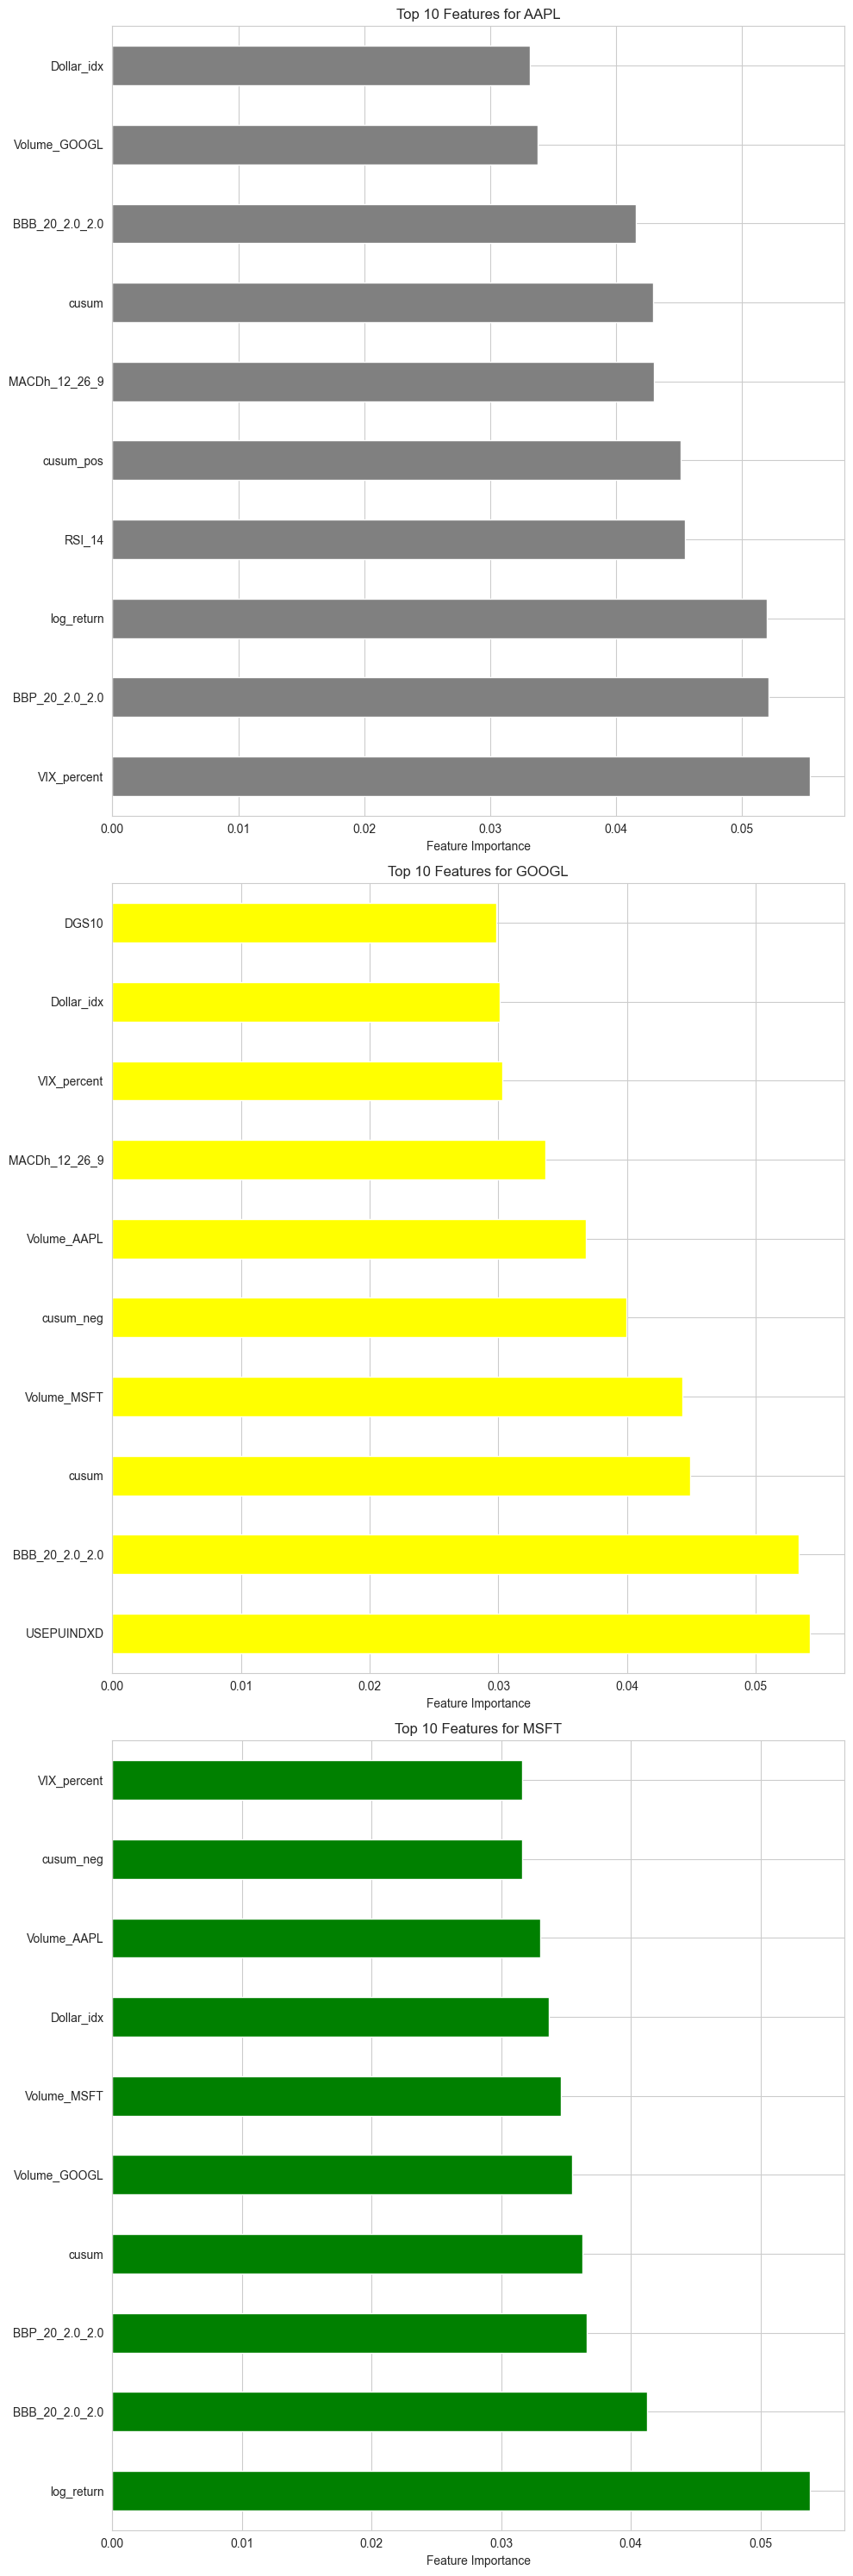

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(10, 30))
result_dict = {}

for i, share in enumerate(tickers):
    df = get_target(data_dict[share], share)
    features = [col for col in df.columns if col not in ['Target', 'index', 'DATE']]
    
    X = df[features]
    y = df['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100,max_depth=4, min_samples_leaf=10, random_state=42, n_jobs=-1))
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred)
    
    print('*' * 40)
    print(f"Results for {share}:")
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("ROC AUC score:", roc_auc)
    print(classification_report(y_test, y_pred))
    result_dict[share] = [acc, precision, recall, roc_auc]
    
    
    importances = pd.Series(pipeline.steps[1][1].feature_importances_, index=features)
    importances.nlargest(10).plot(kind='barh',color=color_dict[share] , title=f'Top 10 Features for {share}', ax=axes[i])
    axes[i].set_xlabel("Feature Importance")
plt.tight_layout()  
plt.show()

In [6]:
df_to_save = pd.DataFrame.from_dict(
    result_dict, 
    orient='index',
    columns=['accuracy', 'precision', 'recall', 'roc_auc']
)
print(df_to_save)
df_to_save.to_csv('../models_results/RF_results.csv')

       accuracy  precision    recall   roc_auc
AAPL   0.532274   0.572728  0.507338  0.507338
GOOGL  0.455809   0.460853  0.462415  0.462415
MSFT   0.503476   0.482232  0.489320  0.489320
